In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from numpy import seterr
seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
import pandas as pd
import numpy as np
import pandapower as pp
import gym
from io import StringIO
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.distributions import Normal
import seaborn as sns
from collections import deque
import time
import matplotlib.pyplot as plt

In [3]:
import torch
print(torch.__version__)          
print(torch.cuda.is_available())  
print(torch.cuda.device_count())  

2.5.1
True
1


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
device

device(type='cuda')

In [6]:
ieee33_data = """
1 2 100 60 0.0461 0.0235 400
2 3 90 40 0.2465 0.1255 400
3 4 120 80 0.1830 0.0932 400
4 5 60 30 0.1905 0.0970 400
5 6 60 20 0.4095 0.3535 400
6 7 200 100 0.0936 0.3094 300
7 8 200 100 0.8558 0.6178 300
8 9 60 20 0.5150 0.3700 200
9 10 60 20 0.5220 0.3700 200
10 11 45 30 0.0983 0.0325 200
11 12 60 35 0.1872 0.0618 200
12 13 60 35 0.7340 0.5774 200
13 14 120 80 0.2708 0.3564 200
14 15 60 10 0.2954 0.2630 200
15 16 60 20 0.3731 0.2724 200
16 17 60 20 0.6444 0.8605 200
17 18 90 40 0.3660 0.2869 200
2 19 90 40 0.0820 0.0782 200
19 20 90 40 0.7521 0.6777 200
20 21 90 40 0.2047 0.2392 200
21 22 90 40 0.3544 0.4686 200
3 23 90 50 0.2256 0.1542 200
23 24 420 200 0.4490 0.3545 200
24 25 420 200 0.4479 0.3505 200
6 26 60 25 0.1015 0.0517 300
26 27 60 25 0.1421 0.0723 300
27 28 60 20 0.5294 0.4669 300
28 29 120 70 0.4021 0.3503 200
29 30 200 600 0.2537 0.1292 200
30 31 150 70 0.4872 0.4814 200
31 32 210 100 0.1552 0.1809 200
32 33 60 40 0.1705 0.2651 200
"""

columns = ['from', 'to', 'P', 'Q', 'rohm', 'xohm', 'maxi']
df33 = pd.read_csv(StringIO(ieee33_data), sep='\s+', header=None, names=columns)



def build_ieee33_case(df):

    net = pp.create_empty_network()


    for i in range(34):
        pp.create_bus(net, vn_kv=33 if i == 0 else 11, name=f"Bus_{i}")


    pp.create_ext_grid(net, bus=0, vm_pu=1.02)

    pp.create_transformer_from_parameters(
        net,
        hv_bus=0,
        lv_bus=1,
        sn_mva=8.0,
        vn_hv_kv=33,
        vn_lv_kv=11,
        vkr_percent=0.12,
        vk_percent=6.0,
        pfe_kw=15,
        i0_percent=0.03
    )


    for _, row in df.iterrows():

        pp.create_line_from_parameters(
            net,
            from_bus=int(row['from']),
            to_bus=int(row['to']),
            length_km=1,
            r_ohm_per_km=float(row['rohm']),
            x_ohm_per_km=float(row['xohm']),
            c_nf_per_km=0,
            max_i_ka=float(row['maxi'])/1000
        )

        pp.create_load(
            net,
            bus=int(row['to']),
            p_mw=float(row['P'])/1000,
            q_mvar=float(row['Q'])/1000
        )

    return net

net = build_ieee33_case(df33)

In [7]:
net = net = build_ieee33_case(df33)

In [8]:
pp.runpp(net)

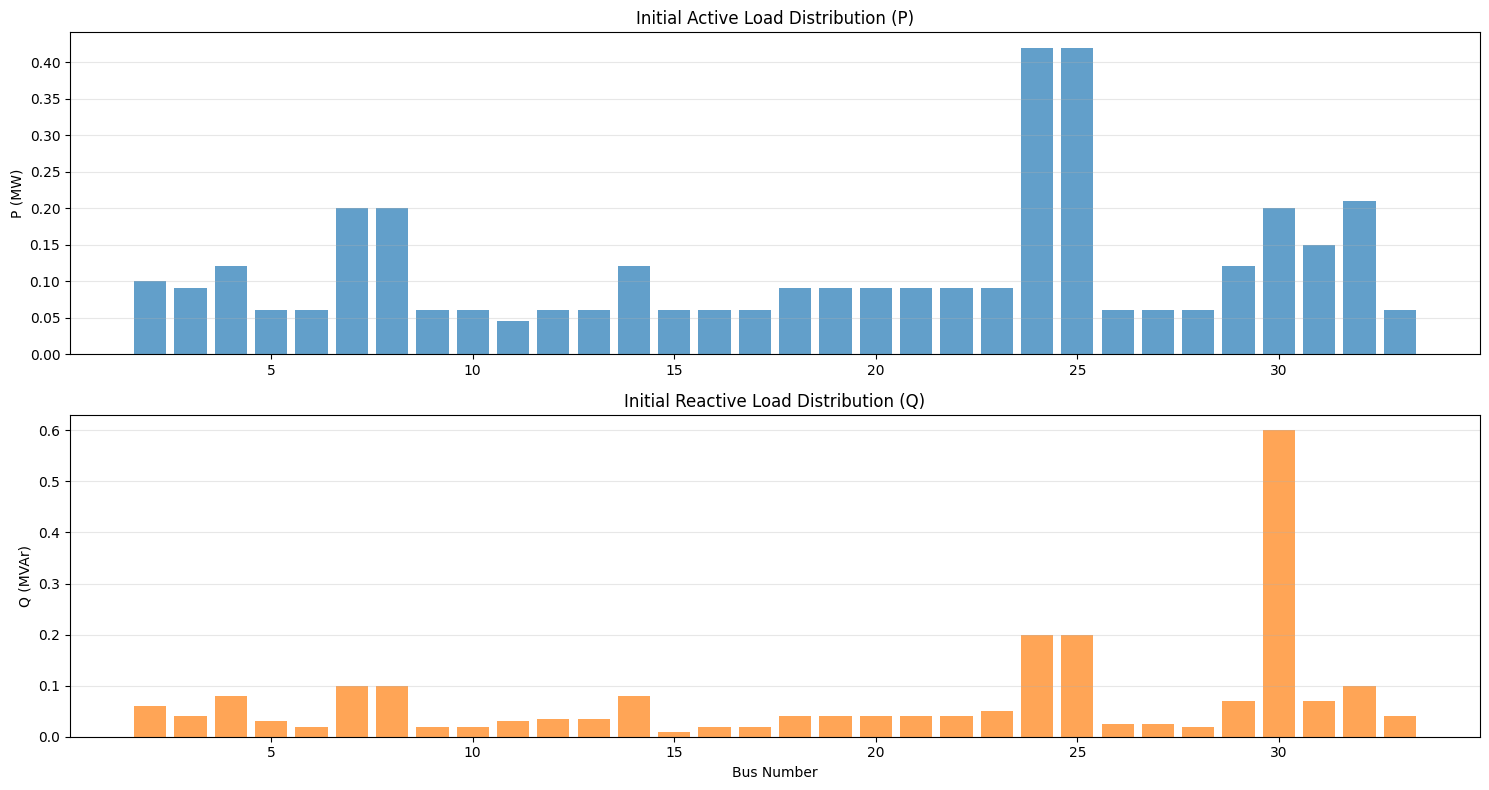

In [9]:
def plot_initial_loads(net):

    load_data = net.load[['bus', 'p_mw', 'q_mvar']]


    load_data = load_data[(load_data['p_mw'] > 0) | (load_data['q_mvar'] > 0)]

    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plt.bar(load_data['bus'], load_data['p_mw'], color='#1f77b4', alpha=0.7, label='Active Power (MW)')
    plt.title('Initial Active Load Distribution (P)')
    plt.ylabel('P (MW)')
    plt.grid(axis='y', alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.bar(load_data['bus'], load_data['q_mvar'], color='#ff7f0e', alpha=0.7, label='Reactive Power (MVAr)')
    plt.title('Initial Reactive Load Distribution (Q)')
    plt.ylabel('Q (MVAr)')
    plt.xlabel('Bus Number')
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

net = build_ieee33_case(df33)
plot_initial_loads(net)

In [10]:
def add_dynamics(net, duration=48, time_step=1,seed=None):
    # np.random.seed(42)
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed() 

    # set parameter for different modes
    MODES = {
        0: {'load_var': 0.4, 'pv_var': 0.7},   # high
        1: {'load_var': 0.1, 'pv_var': 0.4}   # low
    }

    TRANSITION_MATRIX = [
        [0.8, 0.2],
        [0.3, 0.7]
    ]

    # Initialization
    current_mode = 0
    mode_history = [current_mode]

    hours = np.arange(0, duration, time_step)

    # create PV
    base_load = net.load[['p_mw', 'q_mvar']].values.copy()
    pp.create_sgen(net, bus=25, p_mw=0, q_mvar=0, type='PV')
    pp.create_sgen(net, bus=22, p_mw=0, q_mvar=0, type='PV')
    pp.create_sgen(net, bus=13, p_mw=0, q_mvar=0, type='PV')
    pp.create_sgen(net, bus=18, p_mw=0, q_mvar=0, type='PV')
    pp.create_sgen(net, bus=29, p_mw=0, q_mvar=0, type='PV')
    pp.create_sgen(net, bus=33, p_mw=0, q_mvar=0, type='PV')

    voltage_profiles = []
    load_patterns = []

    for t in hours:
        #swith mode
        if t > 0:
            current_mode = np.random.choice(
                2,
                p=TRANSITION_MATRIX[current_mode]
            )
        mode_history.append(current_mode)

        #get parameters
        params = MODES[current_mode]

        #Load fluctuation
        load_factor = 1 + params['load_var'] * (
            np.sin(t/2) + 0.5*np.random.randn(len(base_load))
        )

        #PV fluctuation
        pv_factor = np.clip(
            np.sin(t*np.pi/6) + 0.2*np.random.randn(),
            0, 1
        )


        #update status
        net.load['p_mw'] = base_load[:,0] * load_factor
        net.load['q_mvar'] = base_load[:,1] * load_factor
        net.sgen.p_mw = 2.0 * pv_factor * (1 if 6 <= t%24 <= 18 else 0)

        # power flow calculation
        pp.runpp(net)

        voltage_profiles.append(net.res_bus.vm_pu.copy())
        load_patterns.append(net.load.p_mw.copy())

    return hours, np.array(voltage_profiles), np.array(load_patterns), mode_history

In [11]:
def plot_voltage_dynamics_3(hours, voltages, mode_history):
    plt.figure(figsize=(20, 12))
    ax1 = plt.subplot(2, 1, 1)

    num_buses = voltages.shape[1]

    for bus_idx in range(num_buses):
        ax1.plot(hours, voltages[:, bus_idx],
                linewidth=0.8,
                # alpha=0.7,
                label=f'Bus {bus_idx+1}')

    ax1.set_title('Voltage Profile of All Buses', fontsize=14)
    ax1.set_xlabel('Time (h)', fontsize=12)
    ax1.set_ylabel('Voltage (pu)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    # plt.ylim(0.7, 1.2)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_voltage_dynamics_4(hours, voltages, mode_history):
    plt.figure(figsize=(20, 12))
    ax1 = plt.subplot(2, 1, 1)

    num_buses = voltages.shape[1]

    for bus_idx in range(num_buses):
        ax1.plot(hours, voltages[:, bus_idx],
                linewidth=0.8,
                # alpha=0.7,
                label=f'Bus {bus_idx+1}')

    ax1.set_title('Voltage Profile of All Buses', fontsize=14)
    ax1.set_xlabel('Time (h)', fontsize=12)
    ax1.set_ylabel('Voltage (pu)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    plt.ylim(0.9, 1.1)
    plt.tight_layout()
    plt.show()

In [13]:
net = build_ieee33_case(df33)

hours, voltages, loads, mode_history = add_dynamics(net,48,1,42)

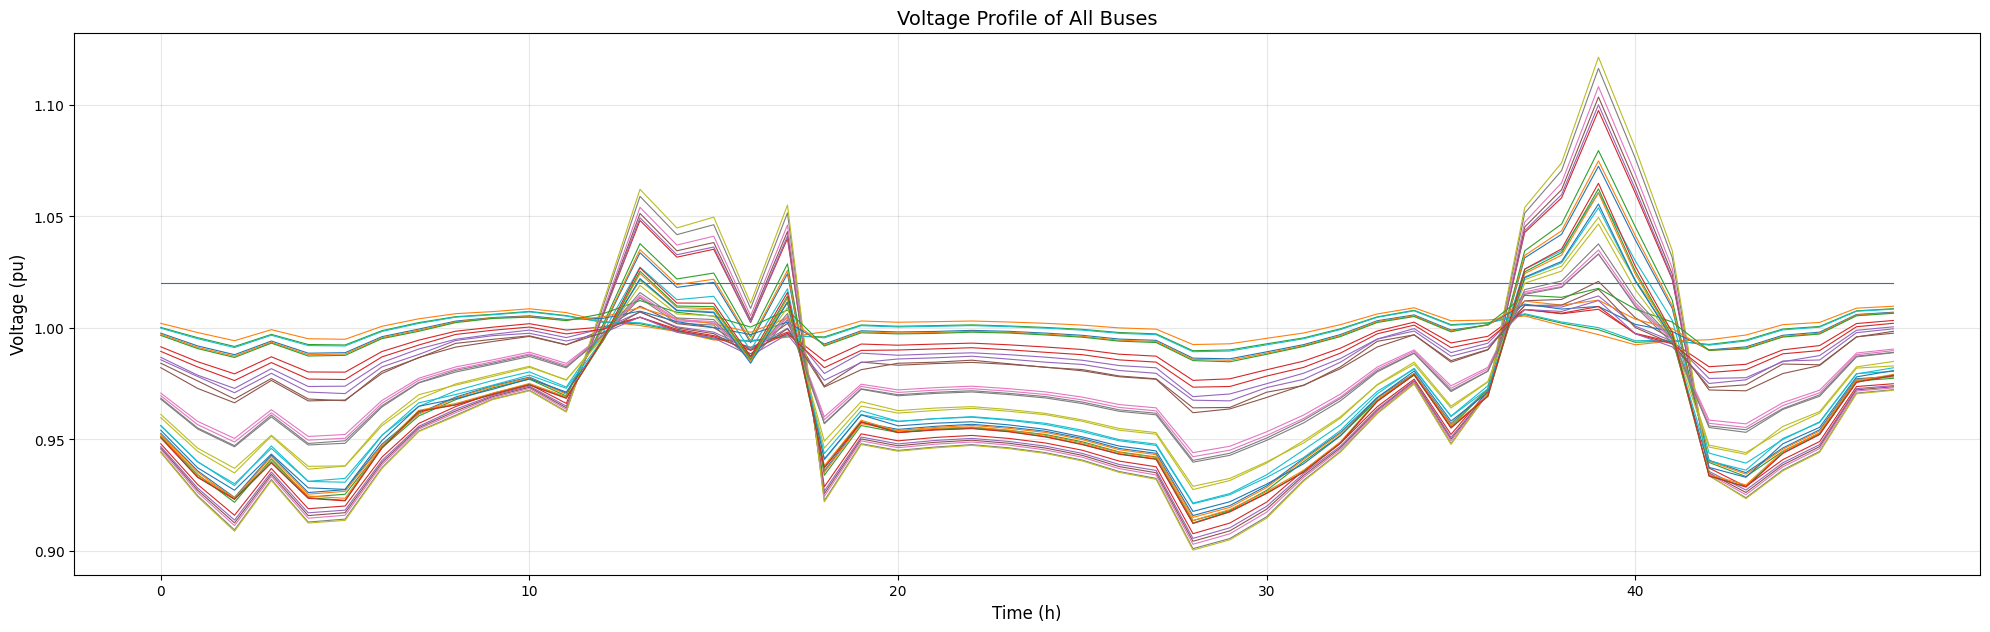

In [14]:
plot_voltage_dynamics_3(hours, voltages, mode_history[:-1])

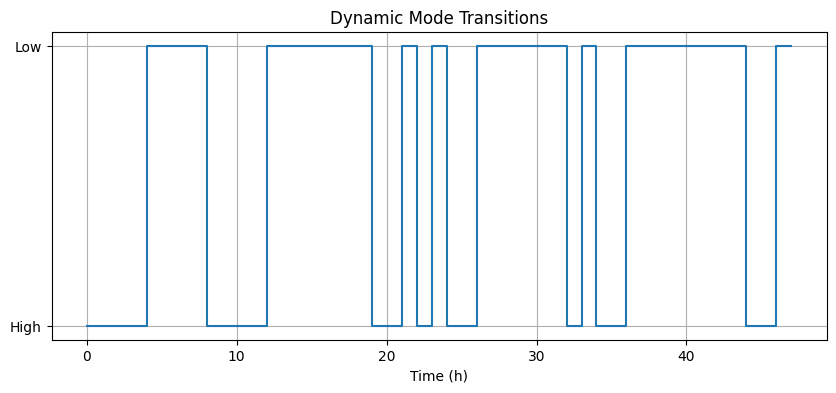

In [15]:
net = build_ieee33_case(df33)

# run dynamic
hours, voltages, loads, mode_history = add_dynamics(net)

plt.figure(figsize=(10,4))
plt.step(hours, mode_history[:-1], where='post')
plt.title('Dynamic Mode Transitions')
plt.yticks([0,1], ['High','Low'])
plt.xlabel('Time (h)')
plt.grid(True)
plt.show()

In [23]:
class NSMAVoltageEnv:
    def __init__(self, num_agents=6):
        self.num_agents = num_agents
        self.net = build_ieee33_case(df33)
        self.control_buses = [13, 18, 22, 25, 29,33]
        self.safe_range = (0.95, 1.05)
        self.max_steps = 48
        self.current_mode = 0
        self.step_count = 0
        _, _, self.precomputed_loads, self.mode_history = add_dynamics(
            self.net, duration=self.max_steps, time_step=1
        )
        self.modes = [
            {
                'action_noise': 0.5,
                'reward_weights': {'voltage': 0.1, 'action': 0.01},
                'transition_matrix': [[0.8, 0.2], [0.3, 0.7]]
            },
            {
                'action_noise': 0.2,
                'reward_weights': {'voltage': 0.05, 'action': 0.005},
                'transition_matrix':[[0.8, 0.2], [0.3, 0.7]]
            }]
        # create 6 PV
        for bus in self.control_buses:
            pp.create_sgen(self.net, bus=bus, p_mw=0, type='PV')

    def reset(self):
        self.step_count = 0
        self.current_mode = 0
        # reset IEEE
        self.net = build_ieee33_case(df33)
        _, _, self.precomputed_loads, self.mode_history = add_dynamics(
            self.net, duration=self.max_steps, time_step=1
        )
        for bus in self.control_buses:
            pp.create_sgen(self.net, bus=bus, p_mw=0, type='PV')
        return self._get_obs()

    def _get_obs(self):
        pp.runpp(self.net)
        obs_list = []
        for bus in self.control_buses:
            v = self.net.res_bus.vm_pu.at[bus]
            load = self.net.load.loc[self.net.load.bus == bus, 'p_mw'].sum()
            obs_list.append([v, load, self.current_mode])
        return np.array(obs_list, dtype=np.float32)

    def step(self, actions,deterministic=False):
        self.step_count += 1
        
        current_loads = self.precomputed_loads[self.step_count-1]
        self.net.load['p_mw'] = current_loads

        mode_params = self.modes[self.current_mode]
        action_noise = mode_params['action_noise']
        
        # get action and add noise
        processed_actions = []
        for action in actions:
            scaled_action = 2.0 * torch.tanh(torch.tensor(action)) 
            if deterministic:
                noisy_action = scaled_action.item()
            else:
                noisy_action = scaled_action.item() + np.random.normal(0, action_noise * 0.1)
            processed_actions.append(np.clip(noisy_action, 0.0, 2.5))            
            
        # apply action
        for bus, action in zip(self.control_buses, processed_actions):
            pv_gen_indices = self.net.sgen[self.net.sgen.bus == bus].index
            if len(pv_gen_indices) > 0:
                self.net.sgen.at[pv_gen_indices[0], 'p_mw'] = action

        # switch mode
        mode_params = self.modes[self.current_mode]
        self.current_mode = np.random.choice(2, p=mode_params['transition_matrix'][self.current_mode])

        new_obs = self._get_obs()
        ##this reward function is for test
        # voltage_errors = [abs(v[0] - 1.0) for v in new_obs]
        # reward = -np.sum(voltage_errors) * 1
        ##below is the reward function used in thesis
        voltage_errors = [abs(v[0] - 1.0) for v in new_obs]
        reward = -np.sum(voltage_errors) * 0.5
        penalty = np.sum([(v[0] < 0.95 or v[0] > 1.05) for v in new_obs]) * 0.5
        reward -= penalty

        done = self.step_count >= self.max_steps
        return new_obs, reward, done, {'mode': self.current_mode}

In [24]:
class NSMAVoltageEnv_test:
    ##same as other environment
    def __init__(self, num_agents=6):
        self.num_agents = num_agents
        self.net = build_ieee33_case(df33)
        self.control_buses = [13, 18, 22, 25, 29,33]
        self.safe_range = (0.95, 1.05)
        self.max_steps = 48
        self.current_mode = 0
        self.step_count = 0
        self.modes = [
            {
                'action_noise': 0.5,
                'reward_weights': {'voltage': 0.1, 'action': 0.01},
                'transition_matrix': [[0.8, 0.2], [0.3, 0.7]]
            },
            {
                'action_noise': 0.2,
                'reward_weights': {'voltage': 0.05, 'action': 0.005},
                'transition_matrix':[[0.8, 0.2], [0.3, 0.7]]
            }]

        for bus in self.control_buses:
            pp.create_sgen(self.net, bus=bus, p_mw=0, type='PV')

    def reset(self):
        self.step_count = 0
        self.current_mode = 0

        self.net = build_ieee33_case(df33)
        for bus in self.control_buses:
            pp.create_sgen(self.net, bus=bus, p_mw=0, type='PV')
        return self._get_obs()

    def _get_obs(self):
        pp.runpp(self.net)
        obs_list = []
        for bus in self.control_buses:
            v = self.net.res_bus.vm_pu.at[bus]
            load = self.net.load.loc[self.net.load.bus == bus, 'p_mw'].sum()
            obs_list.append([v, load, self.current_mode])
        return np.array(obs_list, dtype=np.float32)

    def step(self, actions,deterministic=False):
        self.step_count += 1

        mode_params = self.modes[self.current_mode]
        action_noise = mode_params['action_noise']
        

        processed_actions = []
        for action in actions:
            scaled_action = 2.0 * torch.tanh(torch.tensor(action)) 
            if deterministic:
                noisy_action = scaled_action.item()
            else:
                noisy_action = scaled_action.item() + np.random.normal(0, action_noise * 0.1)
            processed_actions.append(np.clip(noisy_action, 0.0, 1.08))            


        for bus, action in zip(self.control_buses, processed_actions):
            pv_gen_indices = self.net.sgen[self.net.sgen.bus == bus].index
            if len(pv_gen_indices) > 0:
                self.net.sgen.at[pv_gen_indices[0], 'p_mw'] = action


        mode_params = self.modes[self.current_mode]
        self.current_mode = np.random.choice(2, p=mode_params['transition_matrix'][self.current_mode])

        new_obs = self._get_obs()
        voltage_errors = [abs(v[0] - 1.0) for v in new_obs]
        reward = -np.sum(voltage_errors) * 0.5
        penalty = np.sum([(v[0] < 0.95 or v[0] > 1.05) for v in new_obs]) * 0.5
        reward -= penalty
        # voltage_errors = [abs(v[0] - 1.0) for v in new_obs]
        # reward = -np.sum(voltage_errors) * 1
        
        done = self.step_count >= self.max_steps
        return new_obs, reward, done, {'mode': self.current_mode}

In [25]:
class NSMAPolicy(nn.Module):
    def __init__(self, obs_dim=2, action_dim=1, num_agents=6, num_modes=2):
        super().__init__()
        self.num_agents = num_agents
        self.action_dim = action_dim
        self.device = device

        # mode embedding（shared）
        self.mode_embed = nn.Embedding(num_modes, 4)

        # Actor network（each agent have different parameter）
        self.actor_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(obs_dim + 4, 128),  
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.LayerNorm(128),
                nn.Linear(128, action_dim)
            ) for _ in range(num_agents)
        ])

  
        self.log_std = nn.Parameter(torch.zeros(num_agents, action_dim))

        # Critic
        self.critic = nn.Sequential(
            nn.Linear(num_agents * 6, 256), 
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        self.to(device)
        
    def forward(self, obs_batch, return_log_probs=False):
        obs_batch = obs_batch.to(self.device)
        batch_size = obs_batch.size(0)


        mode_ids = obs_batch[:, :, 2].long()  
        mode_emb = self.mode_embed(mode_ids)  

        # mis future
        agent_obs = torch.cat([
            obs_batch[:, :, :2],  
            mode_emb
        ], dim=-1)  # [B, N, 3+4=7]

        # process each agent
        action_means = []
        for i in range(self.num_agents):
            # get observation
            agent_input = agent_obs[:, i, :] 
   
            mean = self.actor_nets[i](agent_input)  
            action_means.append(mean.unsqueeze(1))

        action_means = torch.cat(action_means, dim=1)  


        action_stds = torch.exp(self.log_std).clamp(min=0.1, max=1.0)
        action_stds = action_stds.unsqueeze(0).expand(batch_size, -1, -1)


        dists = Normal(action_means, action_stds)

        if return_log_probs :
            actions = dists.rsample()
            log_probs = dists.log_prob(actions).sum(dim=-1)
            return actions, log_probs, action_means, action_stds

        return action_means, dists

    def get_value(self, obs):

        obs = obs.to(self.device)
        batch_size = obs.size(0)
        mode_ids = obs[:, :, 2].long()
        mode_emb = self.mode_embed(mode_ids)  # [B, N, 4]


        global_obs = torch.cat([
            obs[:, :, :2],
            mode_emb
        ], dim=-1).view(batch_size, -1)  # [B, N*7]

        return self.critic(global_obs)  # [B, 1]

In [43]:
class NSMAPPO:
    def __init__(self, env, lr=3e-4, gamma=0.99, clip_ratio=0.2, gae_lambda=0.90):
        self.env = env
        self.policy = NSMAPolicy(obs_dim=2, num_agents=env.num_agents).to(device)
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=3e-4, weight_decay=1e-5)
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.gae_lambda = gae_lambda
        self.batch_size = 4096
        self.entropy_coef = 0.05
        self.loss_history = []

    def collect_trajectory(self):
        obs = self.env.reset()
        batch = {
            'obs': [], 'actions': [], 'rewards': [],
            'dones': [], 'old_log_probs': [], 'values': []
        }

        for _ in range(self.batch_size):
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)  # [1, N, 3]

            with torch.no_grad():
                # generate actions
                actions, log_probs, _, _ = self.policy(obs_tensor, return_log_probs=True)
                # calculated value
                values = self.policy.get_value(obs_tensor)  


            cpu_actions = actions.squeeze(0).cpu().numpy()
            cpu_log_probs = log_probs.squeeze(0).cpu().numpy()
            cpu_value = values.cpu().item()
            next_obs, reward, done, _ = self.env.step(cpu_actions,deterministic=True)

            # save metrics
            batch['obs'].append(obs)
            batch['actions'].append(cpu_actions)
            batch['rewards'].append(reward)
            batch['dones'].append(done)
            batch['old_log_probs'].append(cpu_log_probs)
            batch['values'].append(cpu_value)

            obs = next_obs if not done else self.env.reset()

        return batch

    def compute_advantages(self, rewards, values, dones):
        advantages = []
        last_advantage = 0
        next_value = 0

        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            last_advantage = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * last_advantage
            advantages.insert(0, last_advantage)
            next_value = values[t]

        advantages = np.array(advantages)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        returns = advantages + values
        return torch.FloatTensor(advantages), torch.FloatTensor(returns)

    def train_step(self):
        batch = self.collect_trajectory()


        obs_tensor = torch.FloatTensor(np.array(batch['obs'])).to(device)  
        actions_tensor = torch.FloatTensor(np.array(batch['actions'])).to(device)  
        old_log_probs = torch.FloatTensor(np.array(batch['old_log_probs'])).to(device)  
        rewards = torch.FloatTensor(batch['rewards'])  
        dones = torch.FloatTensor(batch['dones'])  
        values = torch.FloatTensor(batch['values'])  

        # calculated advantage and return
        advantages, returns = self.compute_advantages(rewards.numpy(), values.numpy(), dones.numpy())
        advantages = torch.FloatTensor(advantages).to(device)
        returns = torch.FloatTensor(returns).to(device)

        # policy undate
        for _ in range(3):
            _, new_log_probs, action_means, action_stds = self.policy(
                obs_tensor, return_log_probs=True
            )

            # clip policy
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages.unsqueeze(-1)
            surr2 = torch.clamp(ratio, 1-self.clip_ratio, 1+self.clip_ratio) * advantages.unsqueeze(-1)
            policy_loss = -torch.min(surr1, surr2).mean()

            # value loss
            current_values = self.policy.get_value(obs_tensor).squeeze()
            value_loss = 0.5 * (current_values - returns).pow(2).mean()

            # entropy
            entropy = Normal(action_means, action_stds).entropy().mean()

            # loss
            total_loss = policy_loss + value_loss - self.entropy_coef * entropy

            # backward
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()

        return total_loss.item()

    def save_model(self, path):
        torch.save({
            'policy_state': self.policy.state_dict(),
            'optimizer_state': self.optimizer.state_dict(),
            'loss_history': self.loss_history
        }, path)

    def load_model(self, path):
        checkpoint = torch.load(path, map_location='cpu')
        self.policy.load_state_dict(checkpoint['policy_state'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state'])
        self.loss_history = checkpoint.get('loss_history', [])

In [49]:
class TrainingPipeline:
    def __init__(self, env, mappo, save_path, test_interval=100, total_episodes=5000):
        self.env = env
        self.mappo = mappo
        
        self.save_path = save_path
        self.test_interval = test_interval
        self.total_episodes = total_episodes

        self.train_metrics = {
            'episode': [], 'total_reward': [], 'voltage_safe_ratio': [], 'loss': []
        }
        self.test_metrics = {
            'episode': [], 'total_reward': [], 'voltage_safe_ratio': []
        }

    def _calculate_voltage_safe_ratio(self, voltages):
        safe_count = np.sum((voltages >= 0.95) & (voltages <= 1.05))
        return safe_count / voltages.size

    def _evaluate_episodes(self, env, num_episodes=3, deterministic=False):
        total_rewards = []
        voltage_records = []

        for _ in range(num_episodes):
            obs = env.reset()
            episode_reward = 0
            done = False

            while not done:
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)

                with torch.no_grad():
                    if deterministic:
                        action_means, _ = self.mappo.policy(obs_tensor)
                        actions = action_means.squeeze(0)
                    else:
                        actions, _, _, _ = self.mappo.policy(obs_tensor, return_log_probs=True)
                        actions = actions.squeeze(0)

                cpu_actions = actions.cpu().numpy()
                next_obs, reward, done, _ = env.step(cpu_actions, deterministic=False)
                episode_reward += reward
                voltage_records.append(env.net.res_bus.vm_pu.values.copy())
                obs = next_obs

            total_rewards.append(episode_reward)

        avg_reward = np.mean(total_rewards)
        safe_ratio = self._calculate_voltage_safe_ratio(np.concatenate(voltage_records))
        return avg_reward, safe_ratio

    def run_training(self):
        best_test_reward = -np.inf
        start_time = time.time()

        for episode in range(1, self.total_episodes + 1):
            loss = self.mappo.train_step()
            self.mappo.loss_history.append(loss)

            # train
            train_reward, train_safe = self._evaluate_episodes(
                self.env, num_episodes=3, deterministic=False
            )
            self.train_metrics['episode'].append(episode)
            self.train_metrics['total_reward'].append(train_reward)
            self.train_metrics['voltage_safe_ratio'].append(train_safe)
            self.train_metrics['loss'].append(loss)

            # test
            if episode % self.test_interval == 0:
                test_reward, test_safe = self._evaluate_episodes(
                self.env, num_episodes=3, deterministic=False
                )
                self.test_metrics['episode'].append(episode)
                self.test_metrics['total_reward'].append(test_reward)
                self.test_metrics['voltage_safe_ratio'].append(test_safe)

                if test_reward > best_test_reward:
                    best_test_reward = test_reward
                    self.mappo.save_model(f"{self.save_path}/best_model.pth")

            # save mode
            if episode % 100 == 0:
                self.mappo.save_model(f"{self.save_path}/model_episode_{episode}.pth")
                pd.DataFrame(self.train_metrics).to_csv(
                    f"{self.save_path}/train_metrics.csv", index=False
                )
                pd.DataFrame(self.test_metrics).to_csv(
                    f"{self.save_path}/test_metrics.csv", index=False
                )

            # print process
            print(
                f"episode {episode}/{self.total_episodes} | "
                f"train time: {(time.time()-start_time)/60:.2f} mins | " 
                f"Loss: {loss:.5f} |"
            )

In [28]:
if __name__ == "__main__":
    env = NSMAVoltageEnv_test(num_agents=6)
    mappo = NSMAPPO(env)
    
    #for test
    try:
        loss = mappo.train_step()
        print(f"test success | Loss: {loss:.4f}")
    except Exception as e:
        print(f"error: {str(e)}")

test success | Loss: 1.6117


In [ ]:
train_env = NSMAVoltageEnv(num_agents=6)

mappo = NSMAPPO(train_env)

pipeline = TrainingPipeline(
    env=train_env,
    mappo=mappo,
    save_path="./voltage_control_models/model_saved/test_1/",
    test_interval=50,
    total_episodes=1500
)

pipeline.run_training()

In [45]:
class MAPPOEvaluator:
    ##evaluator for all buses
    def __init__(self, model_path, num_steps=48):
        self.num_steps = num_steps
        self.env = NSMAVoltageEnv_test(num_agents=6)
        self.policy = NSMAPPO(self.env).policy
        self.policy.load_state_dict(torch.load(model_path, map_location='cpu')['policy_state'])
        self.control_buses = [13, 18, 22, 25, 29,33]

        self.policy.eval()

    def evaluate(self, plot=True):
        obs = self.env.reset()
        voltage_records = []

        for t in range(self.num_steps):
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
            with torch.no_grad():
                actions, _, _, _ = self.policy(obs_tensor, return_log_probs=True)
                actions = actions.squeeze(0).cpu().numpy()

            
            obs, _, done, _ = self.env.step(actions, deterministic=True)

            # record voltage
            voltage_records.append(self.env.net.res_bus.vm_pu.values[1:34].copy())

            if done:
                break


        df = pd.DataFrame(voltage_records, columns=[f"Bus_{i}" for i in range(len(voltage_records[0]))])
        df.insert(0, "TimeStep", np.arange(len(df)))

        if plot:
            self._plot_voltages(df)

        return df

    def _plot_voltages(self, df):
        plt.figure(figsize=(16, 8))
        for col in df.columns[1:]:
            plt.plot(df["TimeStep"], df[col], label=col, linewidth=1.0, alpha=0.8)
        plt.axhline(1.05, color='red', linestyle='--', linewidth=1)
        plt.axhline(0.95, color='red', linestyle='--', linewidth=1)
        plt.title("Voltage Profile Over Time (Controlled by MAPPO)")
        plt.xlabel("Timestep")
        plt.ylabel("Voltage (p.u.)")
        plt.grid(True, alpha=0.3)
        plt.ylim(0.9, 1.1)
        plt.tight_layout()
        plt.show()

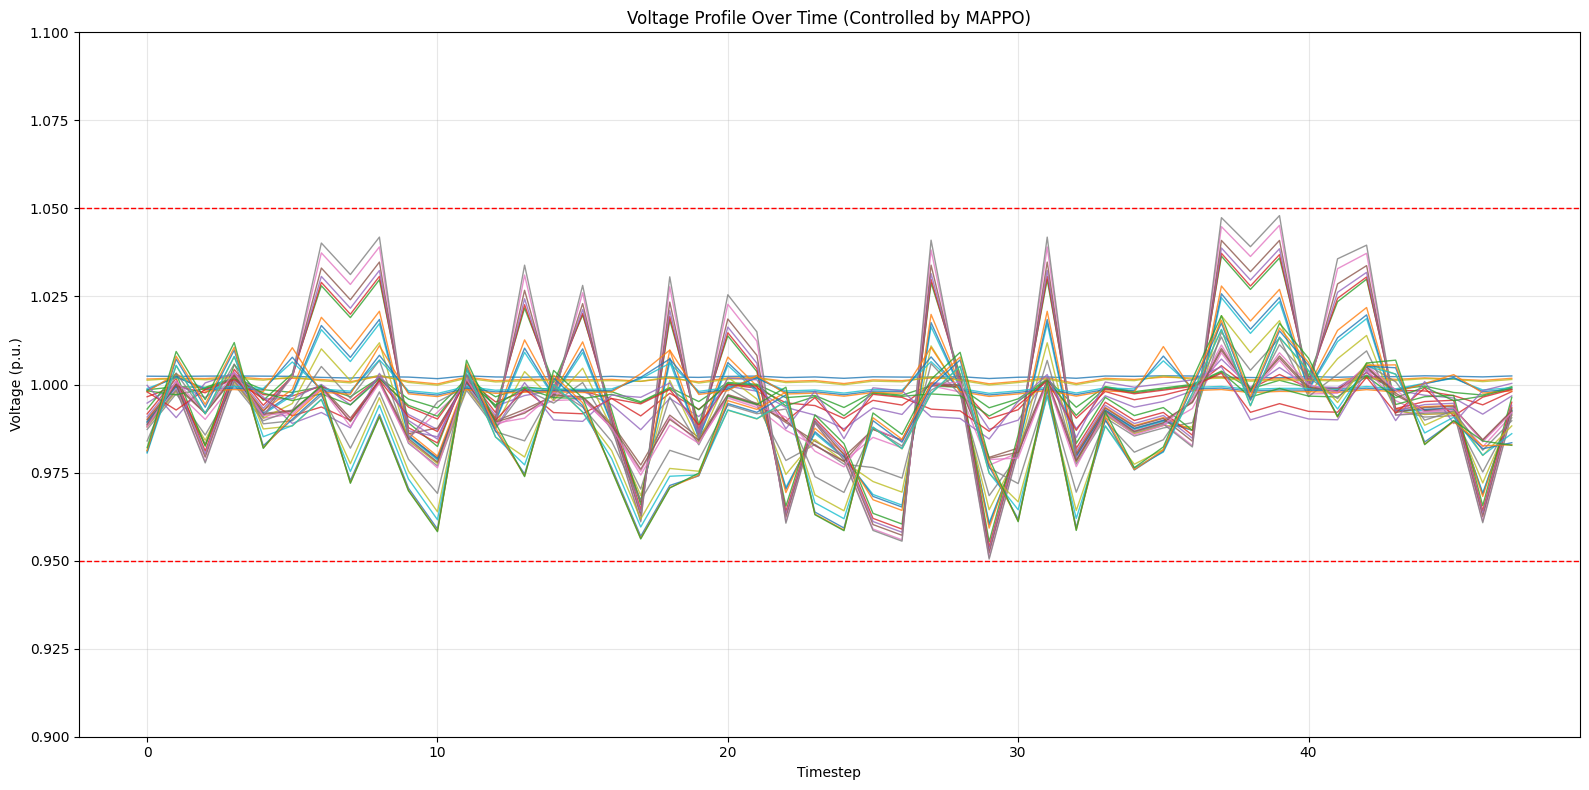

In [195]:
model_path = "./voltage_control_models/for_no_buff/best_model.pth" 
evaluator = MAPPOEvaluator(model_path)
result_df = evaluator.evaluate(plot=True)


In [135]:
class MAPPOTargetEvaluator:
    ##evaluator for selected buses
    def __init__(self, model_path, target_buses=[13, 25], num_steps=48):
        self.num_steps = num_steps
        self.target_buses = target_buses
        self.env = NSMAVoltageEnv_test(num_agents=6)
        self.policy = NSMAPPO(self.env).policy
        self.policy.load_state_dict(torch.load(model_path, map_location='cpu')['policy_state'])
        self.policy.eval()
        
        
        self.color_map = {
            13: '#1f77b4',  
            25: '#ff7f0e'   
        }

    def _get_base_data(self):
        net = build_ieee33_case(df33)
        hours, voltages, _, _ = add_dynamics(net, duration=self.num_steps)
        return hours, voltages[:, 1:34]

    def _get_controlled_data(self):
        obs = self.env.reset()
        controlled_voltages = []
        for _ in range(self.num_steps):
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
            with torch.no_grad():
                actions, _, _, _ = self.policy(obs_tensor, return_log_probs=True)
                actions = actions.squeeze(0).cpu().numpy()
            obs, _, done, _ = self.env.step(actions, deterministic=True)
            controlled_voltages.append(self.env.net.res_bus.vm_pu.values[1:34])
            if done:
                break
        return np.array(controlled_voltages)

    def plot_comparison(self):
        hours, base_data = self._get_base_data()
        ctrl_data = self._get_controlled_data()
        
        for bus in self.target_buses:
            idx = bus - 1  
            plt.figure(figsize=(12, 5))
            
            plt.plot(hours, base_data[:, idx], 
                    color=self.color_map[bus],
                    linestyle='--',
                    linewidth=1.8,
                    label='Uncontrolled')
            plt.plot(hours, ctrl_data[:, idx],
                    color=self.color_map[bus],
                    linewidth=2.2,
                    label='Controlled')
            
            plt.axhspan(0.95, 1.05, alpha=0.1, color='grey', zorder=0)
            plt.axhline(1.05, color='red', linestyle=':', linewidth=1.2, alpha=0.9)
            plt.axhline(0.95, color='red', linestyle=':', linewidth=1.2, alpha=0.9)
            plt.title(f'Voltage Profile Comparison: Bus {bus}', fontsize=14)
            plt.xlabel('Time (hour)', fontsize=12)
            plt.ylabel('Voltage (p.u.)', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.ylim(0.9, 1.1)
            plt.legend(loc='upper right', frameon=True)
            plt.tight_layout()
            plt.show()

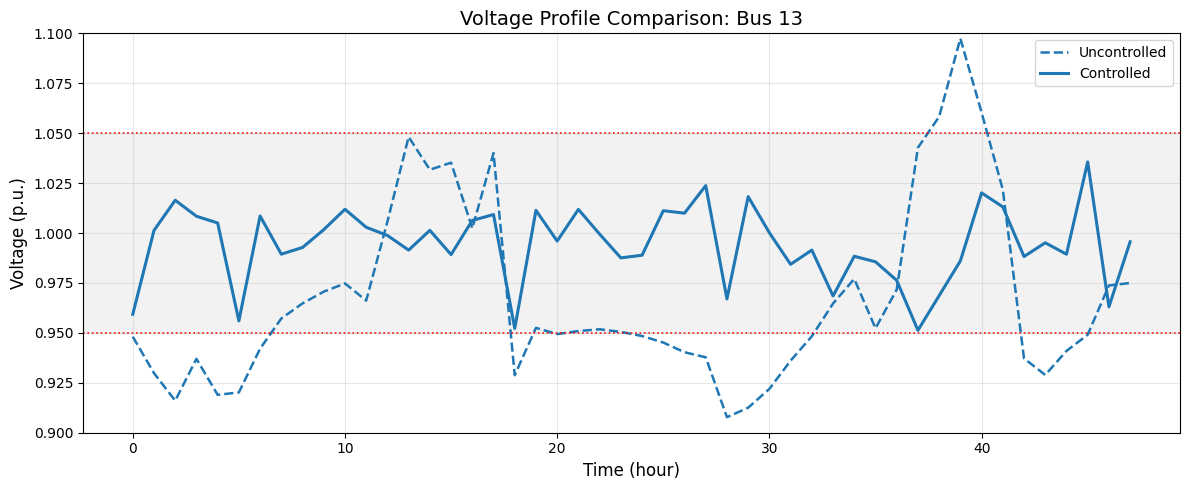

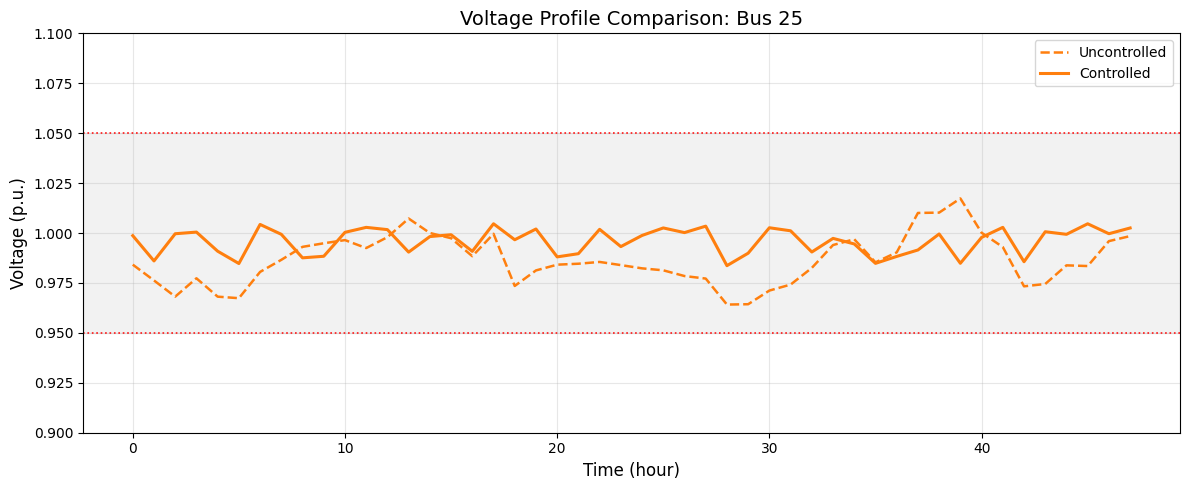

In [140]:
model_path = "./voltage_control_models/for_no_buff/best_model.pth"
evaluator = MAPPOTargetEvaluator(model_path, target_buses=[13, 25])

evaluator.plot_comparison()